## Display and Create RGBa GeoTIFF
 - Create the colormap
 - Get the RGB band from this colormap
 - Create a 3 bands (RGB geotiff) from the 1band GeoTIFF 

Worldwide Glaciers project - IGE - JB Barré - 11/05/2021

In [13]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
import cmocean
import seaborn as sns



In [21]:
# Change the working directory
os.chdir('D:\\3_DataViz\\2_glaciers\\1_data\\THICKNESS\\data_3857\\')
#os.chdir('D:\\3_DataViz\\2_glaciers\\1_data\\VELOCITY\\data_3857\\done\\')
mypath = os.getcwd()
#out_folder = 'D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\'
# Get the content of the folder
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

in_file='THICKNESS_RGI-17.7_2021July23_3857.tif'


In [22]:
# read GeoTIFF source
src = gdal.Open(in_file, gdal.GA_ReadOnly) 

# Note GetRasterBand() takes band no. starting from 1 not 0
band = src.GetRasterBand(1)
nodata = band.GetNoDataValue()
arr = band.ReadAsArray()
arr [arr == 0] =-9999
#Create a masked array for making calculations without nodata values
arr = np.ma.masked_equal(arr, -9999)

In [16]:
np.count_nonzero(arr>10000)

15

<AxesSubplot:>

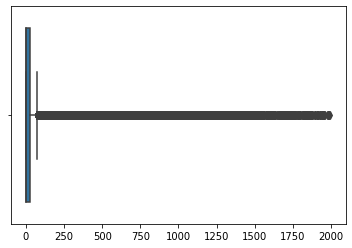

In [23]:
sns.boxplot(np.where(arr>0,arr,0))

In [24]:
(arr.min(), arr.max(), arr.mean(), arr.std())

(1.3136479e-19, 1995.8354, 283.61440300549606, 235.47524248579583)

## Plot scaled GeoTIFF

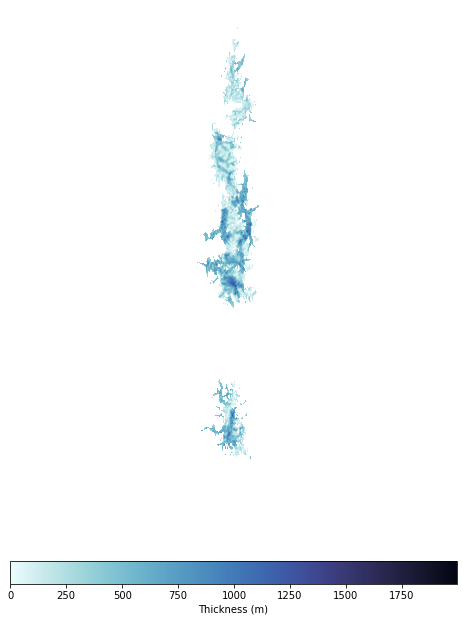

In [25]:
plt.figure(figsize=(10,12))
fig = plt.imshow(arr, origin='lower', cmap=cmocean.cm.ice_r)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig, shrink=0.8,orientation="horizontal")
cb.set_label('Thickness (m)')
#cb.ax.set_yticklabels(tickval)
plt.show()

## From 1 band GeoTIFF to RGBa GeoTIFF

In [26]:
# Normalization du np.array between [0 to 1]
norm_arr =  arr - arr.min() 
norm_arr /= arr.max()-arr.min()
# Apply the colormap to dataset
cmap=cmocean.cm.ice_r
rgb_ds = cmap(norm_arr)
# Scale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
# Round to the nearest bigger integer
data_array_scaled = np.ceil(data_array_scaled)
data_array_scaled = data_array_scaled.astype(int)

print(data_array_scaled.shape)
print(data_array_scaled.min(), data_array_scaled.max())

(11813, 2313, 4)
0 255


In [27]:
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
#free memory


In [8]:
geotransform = src.GetGeoTransform ()
print('originX:',geotransform[0])
print('originY:',geotransform[3])
print('pixelWidth:',geotransform[1])
print('pixelHeight',geotransform[5])
print(data_array_scaled.shape[2]-1)
print(src.RasterXSize)
print(src.RasterYSize)

originX: -17437439.49711719
originY: 10676168.883231105
pixelWidth: 132.5552503777504
pixelHeight -132.5552503777504
3
6892
3573


In [28]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
rgb_file = in_file.replace('.tif','_rgb.tif')

# info from source
geotransform = src.GetGeoTransform ()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]
bands = data_array_scaled.shape[2]-1
rows = src.RasterXSize
cols = src.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2']

# Create new raster
dest = driver.Create(rgb_file,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(255)
# loop through bands and write new values
#or bix in range(3):
#    destb = dest.GetRasterBand(bix+1)
#    #Write array
#    destb.WriteArray(rgb_data[:,:,bix])

destSRS = osr.SpatialReference()
destSRS.ImportFromEPSG(3857)
dest.SetProjection(destSRS.ExportToWkt())

# Close dataset
data_array_scaled= None
del data_array_scaled
dest = None
del dest

In [29]:
# add an alpha band to the RGB for transparent background in Mapbox
rgba_file =rgb_file.replace('rgb','rgba')
rgba_comp_file =rgba_file.replace('.tif','_comp.tif')

#create alpha band
options = gdal.WarpOptions(format='GTiff', srcNodata=0, dstAlpha=True)
dest = gdal.Warp(rgba_file, rgb_file, options=options)
dest = None

#compress GTiff
ds = gdal.Open(rgba_file)
tr_options = gdal.TranslateOptions(creationOptions = ['COMPRESS=LZW','PREDICTOR=2'])
ds = gdal.Translate(rgba_comp_file, ds,options=tr_options)
ds = None

In [30]:
#delete uncompress rgba_file
os.remove(rgba_file)
os.remove(rgb_file)

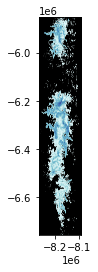

<AxesSubplot:>

In [31]:
fp = rgba_comp_file
img = rasterio.open(fp)
show(img)


In [32]:
img= None
del img